In [25]:
import pandas as pd
import re

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    work_title = ''
    subdiv_title = ''
    
    for line in lines:
        line = line.strip()
        if line.startswith('==') and line.endswith('=='):
            work_title = line[2:-2].strip()
        elif line.startswith('__') and line.endswith('__'):
            subdiv_title = line[2:-2].strip()
        elif line:
            # Look for lines with text surrounded by brackets []
            match = re.match(r'^\[(.+?)\](.*)$', line)
            if match:
                subdiv_title = match.group(1).strip()
                line = match.group(2).strip()
            data.append((work_title, subdiv_title, line))
    
    df = pd.DataFrame(data, columns=['Work Title', 'Subdivision Title', 'Line'])
    return df

# Replace 'path_to_text_file.txt' with the path to your annotated text file
df = preprocess_text('Creep.txt')
df.to_csv('Creep.csv', index=False)

print(f"Lyrics have been saved to 'creep.csv'")


Lyrics have been saved to 'creep.csv'


In [14]:
df = pd.read_csv('preprocessed_lyrics.csv')

In [15]:
df.head()

,Work Title,Subdivision Title,Line
0,Radiohead,Intro,When you were here before
1,Radiohead,Intro,Couldn't look you in the eye
2,Radiohead,Verse 1,You're just like an angel
3,Radiohead,Verse 1,Your skin makes me cry
4,Radiohead,Verse 2,You float like a feather


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(dataframe):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(dataframe['Line'])
    return tfidf_matrix, vectorizer

tfidf_matrix, vectorizer = vectorize_text(df)


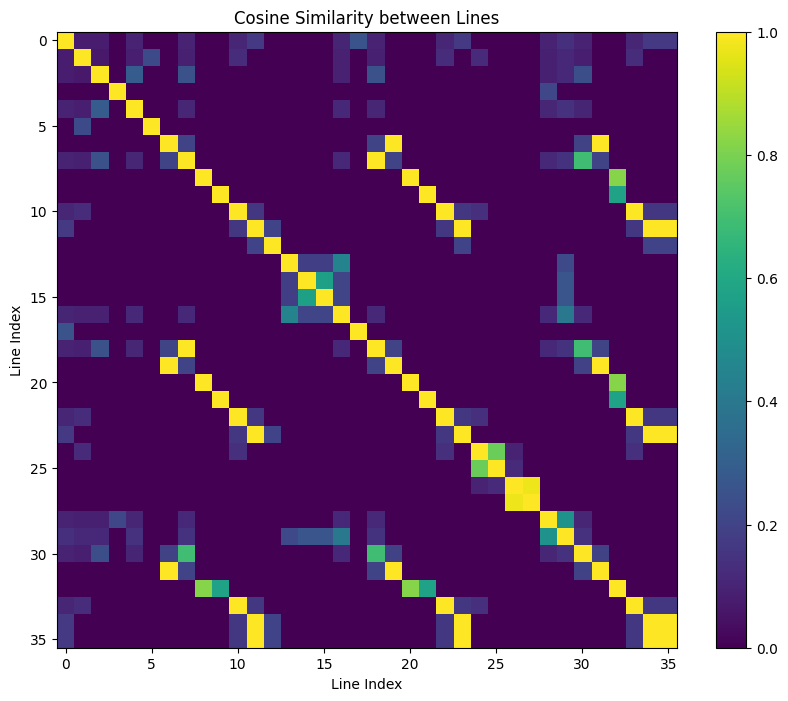

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def visualize_similarity(tfidf_matrix):
    cosine_sim = cosine_similarity(tfidf_matrix)
    plt.figure(figsize=(10, 8))
    plt.imshow(cosine_sim, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Cosine Similarity between Lines')
    plt.xlabel('Line Index')
    plt.ylabel('Line Index')
    plt.show()

visualize_similarity(tfidf_matrix)


In [18]:
def compute_fractal_dimension(cosine_sim, threshold=0.5):
    points = np.argwhere(cosine_sim > threshold)
    distances = np.sqrt((points[:, 0] - points[:, 1])**2)
    radii = np.linspace(1, distances.max(), 50)
    mass = [np.sum(distances < r) for r in radii]
    
    log_radii = np.log(radii)
    log_mass = np.log(mass)
    
    slope, _ = np.polyfit(log_radii, log_mass, 1)
    fractal_dimension = slope
    return fractal_dimension

fractal_dimension = compute_fractal_dimension(cosine_sim)
print(f"Fractal Dimension: {fractal_dimension}")


Fractal Dimension: 0.8985273836710775


In [19]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input text
input_ids = []
for line in df['Line']:
    encoded_line = tokenizer.encode(line, add_special_tokens=True)
    input_ids.append(encoded_line)

# Pad sequences to ensure uniform length
input_ids = torch.tensor([x + [0]*(max(map(len, input_ids))-len(x)) for x in input_ids])

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')

# Generate embeddings
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.mean(dim=1)


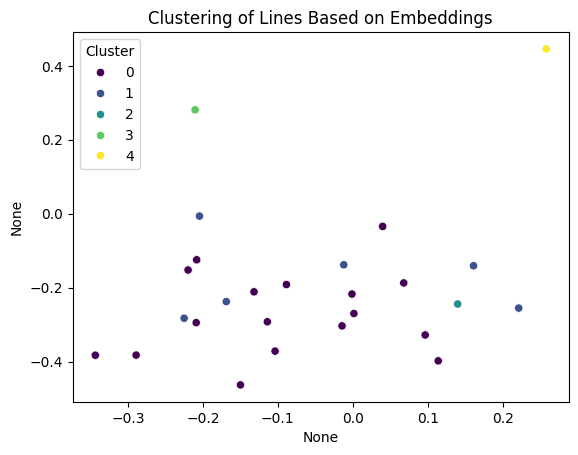

In [20]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
df['Cluster'] = kmeans.labels_

# Visualize clusters
sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=df['Cluster'], palette='viridis')
plt.title('Clustering of Lines Based on Embeddings')
plt.show()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\anshu\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\anshu\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anshu\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\anshu\AppData\Local\Temp\ipykernel_10288\807098010.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment'], palette='coolwarm')


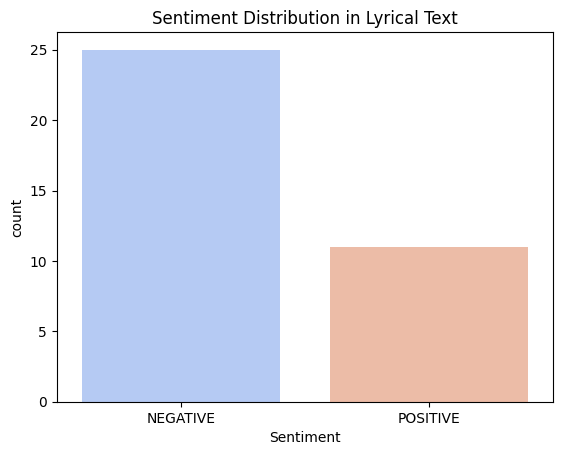

In [21]:
from transformers import pipeline

# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis')

# Analyze sentiment of each line
df['Sentiment'] = df['Line'].apply(lambda x: sentiment_analyzer(x)[0]['label'])

# Visualize sentiment distribution
sns.countplot(x=df['Sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution in Lyrical Text')
plt.show()


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_sim = cosine_similarity(embeddings)


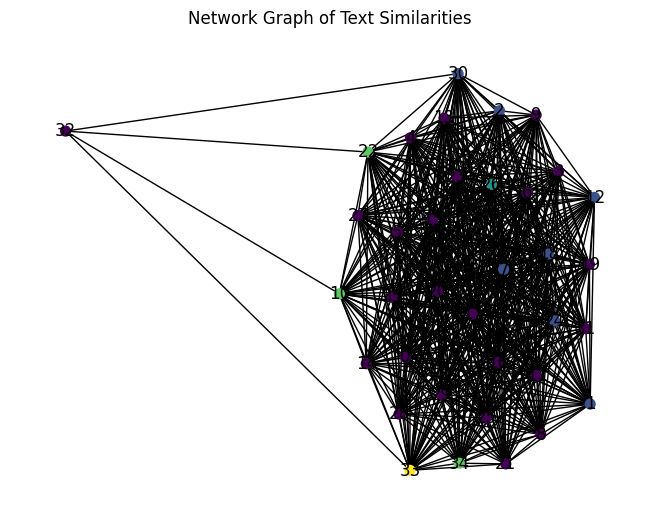

In [23]:
import networkx as nx

# Create a graph based on cosine similarity
G = nx.Graph()
threshold = 0.5
for i in range(len(cosine_sim)):
    for j in range(i+1, len(cosine_sim)):
        if cosine_sim[i, j] > threshold:
            G.add_edge(i, j, weight=cosine_sim[i, j])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=df['Cluster'], with_labels=True, node_size=50, cmap=plt.cm.viridis)
plt.title('Network Graph of Text Similarities')
plt.show()


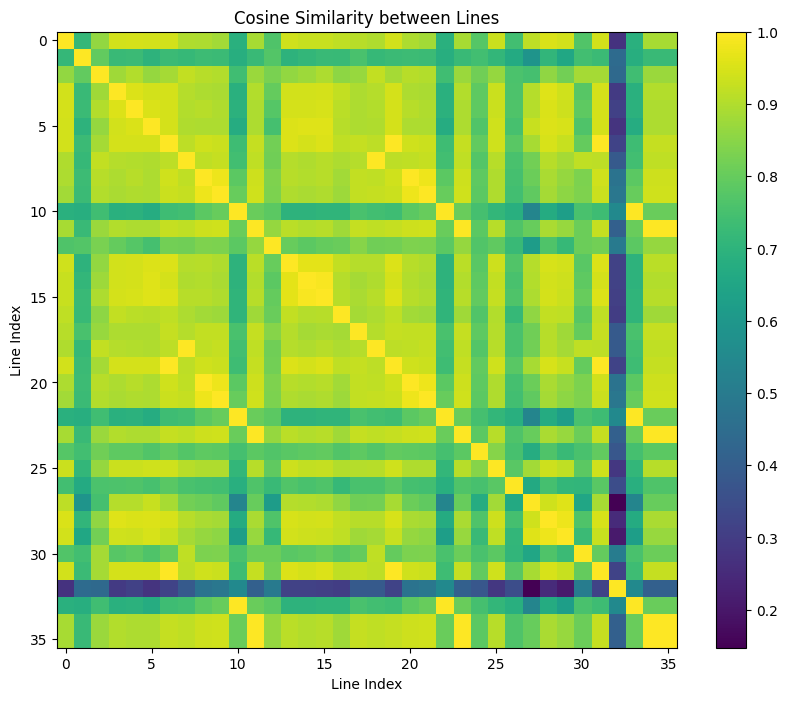

In [24]:
import matplotlib.pyplot as plt

def visualize_similarity(cosine_sim):
    plt.figure(figsize=(10, 8))
    plt.imshow(cosine_sim, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Cosine Similarity between Lines')
    plt.xlabel('Line Index')
    plt.ylabel('Line Index')
    plt.show()

visualize_similarity(cosine_sim)
